In [1]:
import torchvision
from torchvision import transforms

image_path = './'
transform = transforms.Compose([
    transforms.ToTensor()
])

In [2]:
mnist_dataset = torchvision.datasets.MNIST(
    root=image_path, train=True, transform=transform, download=True)
from torch.utils.data import Subset

mnist_valid_dataset = Subset(mnist_dataset, range(10000))
mnist_train_dataset = Subset(mnist_dataset, range(10000, len(mnist_dataset)))

mnist_test_dataset = torchvision.datasets.MNIST(
    root=image_path, train=False, transform=transform, download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 3880612.22it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 91884.95it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1070948.08it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4151346.43it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
import torch
from torch.utils.data import DataLoader
torch.manual_seed(1)

train_dl = DataLoader(mnist_train_dataset, batch_size=64, shuffle=True)
valid_dl = DataLoader(mnist_valid_dataset, batch_size=64, shuffle=False)

In [15]:
import torch.nn as nn

model = nn.Sequential()
model.add_module(
    'conv1', nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2))

model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))
model.add_module(
    'conv2',
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))
model.add_module('flatten', nn.Flatten())
model.add_module('fc1', nn.Linear(3136, 1024))
model.add_module('relu3', nn.ReLU())
model.add_module('dropout', nn.Dropout(0.5))
model.add_module('fc2', nn.Linear(1024, 10))

In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [17]:
def train(model, num_epochs, train_dl, valid_dl):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        for i, (images, labels) in enumerate(train_dl):
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        train_loss /= len(train_dl)
        train_acc = correct_train / total_train
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)
        
        model.eval()
        valid_loss = 0.0
        correct_valid = 0
        total_valid = 0
        with torch.no_grad():
            for i, (images, labels) in enumerate(valid_dl):
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                valid_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total_valid += labels.size(0)
                correct_valid += (predicted == labels).sum().item()
        
        valid_loss /= len(valid_dl)
        valid_acc = correct_valid / total_valid
        val_loss_history.append(valid_loss)
        val_acc_history.append(valid_acc)

        if epoch % 10 == 0:
            print(f'Epoch: {epoch}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}, Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.2f}')
            
    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

In [18]:
num_epochs = 10

train_loss_history, train_acc_history, val_loss_history, val_acc_history = train(
    model, num_epochs, train_dl, valid_dl)

Epoch: 0/10, Train Loss: 0.1659, Train Acc: 0.95, Valid Loss: 0.0555, Valid Acc: 0.98


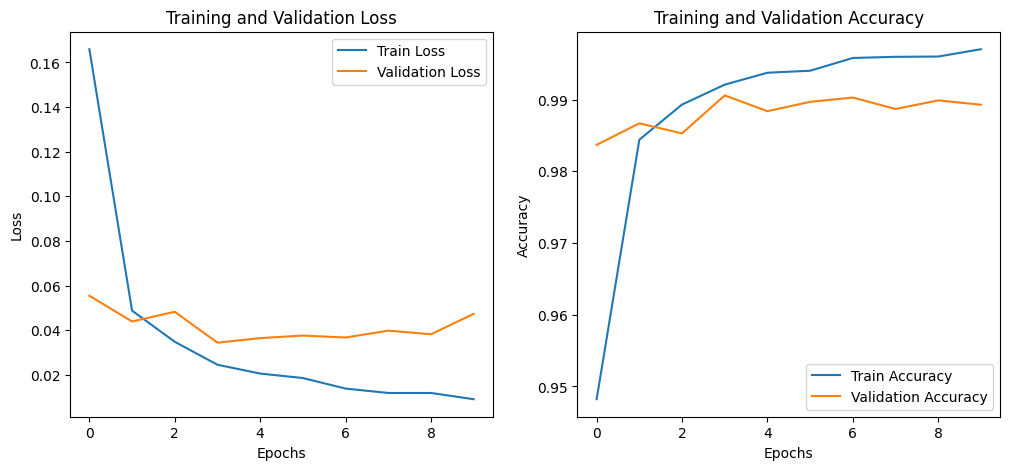

In [19]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [20]:
def test(model, test_dl):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_dl:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy

test_dl = DataLoader(mnist_test_dataset, batch_size=64, shuffle=False)
test_accuracy = test(model, test_dl)
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.9929


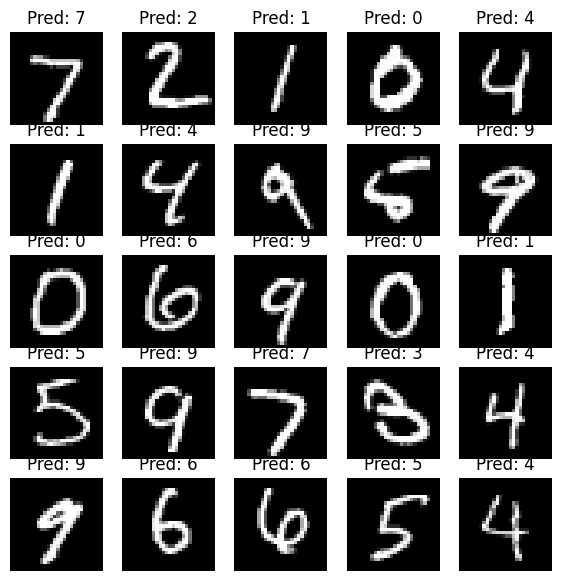

In [23]:
import matplotlib.pyplot as plt

def plot_predictions(model, data_loader, num_images=25):
    model.eval()
    images, labels = next(iter(data_loader))
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    
    plt.figure(figsize=(7, 7))
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f'Pred: {preds[i].item()}')
        plt.axis('off')
    plt.show()

plot_predictions(model, test_dl)